# Analysis

This notebook analysis the results of the FL experiments, beginning with the first stage results. It will not only contain code and graphics, but also text describing the findings. This is in order to find the proper direction of research and to make writing the thesis chapter more easier afterwards.
The first stage analyses a wide range of FL models. The idea is to find similarities and differences between them. Therefore, this part heavily emphasizes on desprictive statistics of the collection of results.
The second stage focuses on specific results. The underlying model is more examined and potentential reasons for the unusual performances are considered. 

## Stage One - A Broad View on the Results 

In [1]:
#import libraries
import numpy as np
import pandas as pd

import tensorflow as tf
import sklearn as sk

import seaborn as sns
import matplotlib.pyplot as plt
import statsmodels.api as sm

2023-02-07 13:41:52.906046: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-02-07 13:41:53.537796: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-02-07 13:41:53.537897: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory
2023-02-07 13:41:53.537906: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Cannot dlopen some TensorRT libraries. If you would like to use Nv

In [4]:
#load data
df = pd.read_json("../logs.json")
df.head()

,date,model,dataset,rounds,losses_distributed,time,number_of_clients,entries,number_of_samples,attributes,stations,scenario,percentage_of_testing_data,loss,epochs,hidden_layers
0,1970-01-01,linear regression,weather,2,"[[1, 0.2226459577], [2, 0.2234555605]]","[[1, 10576.5143687], [2, 10576.5348202]]",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5
1,1970-01-01,linearSVR,weather,2,"[[1, 0.2140126819], [2, 0.21787175820000002]]","[[1, 10586.9262073], [2, 10586.9975151]]",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5
2,1970-01-01,MLP,weather,2,"[[1, 0.2242389992], [2, 0.2104952633]]","[[1, 10601.58299], [2, 10604.0674518]]",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,2,2
3,1970-01-01,MLP,weather,2,"[[1, 0.21910745650000002], [2, 0.2258445099000...","[[1, 10617.884518], [2, 10619.4994774]]",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,2,2
4,1970-01-01,MLP,weather,2,"[[1, 0.2284888551], [2, 0.22254440190000002]]","[[1, 10634.7649193], [2, 10638.9479927]]",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,2,3


In [6]:
#print information
print(f"""
Length: {len(df.index)}
Covid entries: {len(df[df.dataset == "covid"].index)}
Weather entries: {len(df[df.dataset == "weather"].index)}
Contains Nans: {df.isnull().values.any()}
""")


Length: 223
Covid entries: 72
Weather entries: 151
Contains Nans: False



In [8]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
rounds,223.0,3.964126,2.802599e+00,2.0,2.0,2.0,4.0,10.0
number_of_clients,223.0,3.004484,1.002240e+00,2.0,2.0,4.0,4.0,4.0
entries,223.0,10.000000,0.000000e+00,10.0,10.0,10.0,10.0,10.0
number_of_samples,223.0,39058.295964,4.217628e+04,10000.0,10000.0,10000.0,100000.0,100000.0
percentage_of_testing_data,223.0,0.200000,2.781802e-17,0.2,0.2,0.2,0.2,0.2
epochs,223.0,7.452915,3.735184e+00,2.0,2.0,10.0,10.0,10.0
hidden_layers,223.0,3.071749,8.874805e-01,2.0,2.0,3.0,4.0,5.0


The next part examines characteristics of each use case. 

### Weather dataset

In [10]:
#get horizontal use case
weather_df = df[df.dataset == "weather"]

In [13]:
#print general information
print(f"""
Linear Regression entries: {len(weather_df[weather_df.model == "linear regression"].index)}
LinearSVR entries: {len(weather_df[weather_df.model == "linearSVR"].index)}
MLP entries: {len(weather_df[weather_df.model == "MLP"].index)}
LSTM entries: {len(weather_df[weather_df.model == "LSTM"].index)}
CNN entries: {len(weather_df[weather_df.model == "CNN"].index)}
""")


Linear Regression entries: 4
LinearSVR entries: 4
MLP entries: 47
LSTM entries: 48
CNN entries: 48



The first interesting is to see how well the best model of every algorithm performed.

In [30]:
models = ["linear regression", "linearSVR", "MLP", "LSTM", "CNN"]
best_weather_performance = pd.DataFrame(columns=weather_df.columns)
for i, model in enumerate(models):
    df_copy = weather_df[weather_df.model == model].copy(deep=True)
    df_copy["losses_distributed"] = df_copy["losses_distributed"].apply(lambda x: x[-1][-1])
    best_weather_performance = pd.concat([best_weather_performance, df_copy.sort_values(by=["losses_distributed"], ascending=True).iloc[0:1, :]], ignore_index=True)

best_weather_performance.head()
    

,date,model,dataset,rounds,losses_distributed,time,number_of_clients,entries,number_of_samples,attributes,stations,scenario,percentage_of_testing_data,loss,epochs,hidden_layers
0,1970-01-01,linear regression,weather,4,0.217215,"[[1, 11919.1425425], [2, 11919.1607451], [3, 1...",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5
1,1970-01-01,linearSVR,weather,4,0.217683,"[[1, 11929.5103741], [2, 11929.5911009], [3, 1...",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,5
2,1970-01-01,MLP,weather,4,0.182570,"[[1, 12347.0479739], [2, 12356.8283852], [3, 1...",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,4
3,1970-01-01,LSTM,weather,4,0.206540,"[[1, 12775.0664505], [2, 12805.5933949], [3, 1...",2,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,10,2
4,1970-01-01,CNN,weather,2,0.820922,"[[1, 15203.3189626], [2, 15206.9521501]]",4,10,10000,"[temp, rhum, dwpt]","[berlin_alexanderplatz, frankfurt_am_main_west...",separate,0.2,MAE,2,4


The CNN has an unusal high loss. It is also interesting to see the MLP model performing better than the LSTM.

<AxesSubplot: xlabel='model', ylabel='losses_distributed'>

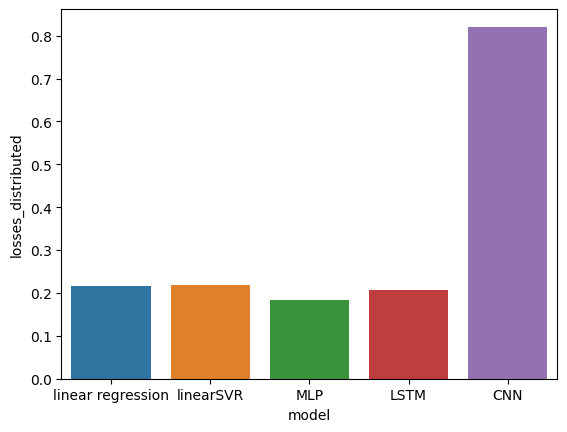

In [31]:
sns.barplot(data=best_weather_performance, x="model", y="losses_distributed")